# Eluvio Data Science Challenge: Modeling Notebook 1

####Target Variable: "over_18" feature
####Models: BERT Classification Model & Stacked Ensemble with XGBoost Classifier

- For this predictive model, our target variable will be "over_18". The metric we are optimizing for is recall given that the dataset set is so imbalanced. We will use random undersampling to significantly undersample the majority class while retaining all minority class samples. 

- For this model, we had success with a  max length for the text input into the BERT encoder of 150 characters; while a longer text length would have been beneficial it was too computationally expensive for this analyis, future analyses would benefit from a character length of 300, given that is the longest text length in this dataset. 

- Given the imbalanaced nature of the dataset, even after random undersampling, the BERT model was not optimizing for the minority class, thus class weights were used in the Keras model API to adjust the loss function to be more sensitive to the minority class. With only the BERT model we achieved a recall score of 67%. When we employed a stacked ensemble model, feeding the outputs of the BERT model into a XGBoost model, precision improved by 8%.





In [1]:
!pip install sentencepiece
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,auc
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from datetime import datetime
import time
import tensorflow as tf
import keras
import tensorflow_hub as hub
import logging

logging.basicConfig(level=logging.INFO)

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Eluvio_Challenge/')

import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print('\nGPU:\n', gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:absl:Using /tmp/tfhub_modules to cache modules.



GPU:
 Tue Apr 20 04:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   1375MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [2]:
data = pd.read_csv('data/Eluvio_DS_Challenge_cleaned_wrangled.csv', index_col=0)

In [3]:
data.head(2)

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,month,year,hour_period,season,nsfc,char_count,word_count,flesch_readability,flesch_grade
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,1,2008,Late_Night,Q1,True,33,5,83.32,2.9
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,1,2008,Late_Night,Q1,False,32,4,33.58,9.6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509236 entries, 0 to 509235
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time_created        509236 non-null  object 
 1   up_votes            509236 non-null  int64  
 2   title               509236 non-null  object 
 3   over_18             509236 non-null  bool   
 4   author              509236 non-null  object 
 5   clock_time          509236 non-null  object 
 6   hour                509236 non-null  int64  
 7   day_of_week         509236 non-null  int64  
 8   month               509236 non-null  int64  
 9   year                509236 non-null  int64  
 10  hour_period         509236 non-null  object 
 11  season              509236 non-null  object 
 12  nsfc                509236 non-null  bool   
 13  char_count          509236 non-null  int64  
 14  word_count          509236 non-null  int64  
 15  flesch_readability  509236 non-nul

### Feature Engineering


In [5]:
# creating training and test datasets for model evaluation
train,test =train_test_split(data,test_size = 0.15, random_state=42)

In [6]:
print(train.shape)
test.shape

(432850, 17)


(76386, 17)

In [7]:
train.over_18.value_counts()

False    432579
True        271
Name: over_18, dtype: int64

In [8]:
test.over_18.value_counts()

False    76337
True        49
Name: over_18, dtype: int64

### Random Undersampling 
- Undersampling the majority class of the "over_18" variable, keeping all minority samples (as there are only "over_18" 320 observations in over 500,000 posts). Undersampling the majority class in the training data down to 50,000 and 5,000 in test data.

In [9]:
train_majority_class = train[train.over_18==False]
train_minority_class = train[train.over_18==True]
train_majority_class = train_majority_class.sample(n=10000)

train = pd.concat([train_majority_class,train_minority_class]).sort_index()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [10]:
train.over_18.value_counts()

False    10000
True       271
Name: over_18, dtype: int64

In [11]:
test_majority_class = test[test.over_18==False]
test_minority_class = test[test.over_18==True]
test_majority_class = test_majority_class.sample(n=1000)

test = pd.concat([test_majority_class,test_minority_class]).sort_index()

In [12]:
test.over_18.value_counts() 

False    1000
True       49
Name: over_18, dtype: int64

In [13]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

## Encoding Text for BERT Model

In [14]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [15]:
from keras.regularizers import l1_l2

def build_model(bert_layer, max_len=512):

    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output) 
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net) 
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)
    
    optimizer = tf.keras.optimizers.Adam(lr=5e-6) 

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
%%time 

max_len = 150
train_input = bert_encode(train.title.values, tokenizer, max_len=max_len)
train_labels = keras.utils.to_categorical(train.over_18.values, num_classes=2)

CPU times: user 3.34 s, sys: 28.6 ms, total: 3.36 s
Wall time: 3.36 s


## Building BERT Model

In [17]:
#from tensorflow.keras import regularizers

model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [18]:
# file_path for saving model
model_folder = '/content/drive/MyDrive/Eluvio_Challenge/data/'
mode_name = 'bert_model_5.h5'
file_path = model_folder + mode_name

checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

class_weight = {0: 1.,
                1: 30.}

history = model.fit(
    train_input, train_labels, 
    validation_split=0.15,
    epochs=20,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20
273/273 [==============================] - 179s 612ms/step - loss: 1.3079 - accuracy: 0.5542 - val_loss: 0.3222 - val_accuracy: 0.9098

Epoch 00001: val_loss improved from inf to 0.32216, saving model to /content/drive/MyDrive/Eluvio_Challenge/data/bert_model_5.h5
Epoch 2/20
273/273 [==============================] - 166s 608ms/step - loss: 0.8673 - accuracy: 0.8490 - val_loss: 0.2376 - val_accuracy: 0.9182

Epoch 00002: val_loss improved from 0.32216 to 0.23760, saving model to /content/drive/MyDrive/Eluvio_Challenge/data/bert_model_5.h5
Epoch 3/20
273/273 [==============================] - 166s 608ms/step - loss: 0.6124 - accuracy: 0.8967 - val_loss: 0.1256 - val_accuracy: 0.9585

Epoch 00003: val_loss improved from 0.23760 to 0.12555, saving model to /content/drive/MyDrive/Eluvio_Challenge/data/bert_model_5.h5
Epoch 4/20
273/273 [==============================] - 166s 608ms/step - loss: 0.4120 - accuracy: 0.9285 - val_loss: 0.1181 - val_accuracy: 0.9559

Epoch 00004: val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


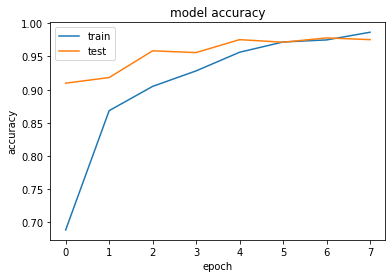

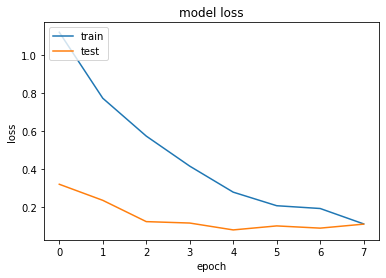

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading Saved Model

In [40]:
# Loading Saved Model Weights
saved_model_folder = "/content/drive/MyDrive/Eluvio_Challenge/data/"
model_name = 'bert_model_5.h5'

file_path = saved_model_folder + model_name
max_len = 150

model = build_model(bert_layer, max_len=max_len)
model.load_weights(file_path)

In [20]:
%%time
test_true = test.over_18

test_labels = keras.utils.to_categorical(test_true.values, num_classes=2)
test_input = bert_encode(test.title.values, tokenizer, max_len=max_len)

test_pred = model.predict(test_input)
test_pred = test_pred.argmax(1)

CPU times: user 1.42 s, sys: 362 ms, total: 1.78 s
Wall time: 7.17 s


              precision    recall  f1-score   support

       False       0.98      0.97      0.98      1000
        True       0.54      0.67      0.60        49

    accuracy                           0.96      1049
   macro avg       0.76      0.82      0.79      1049
weighted avg       0.96      0.96      0.96      1049



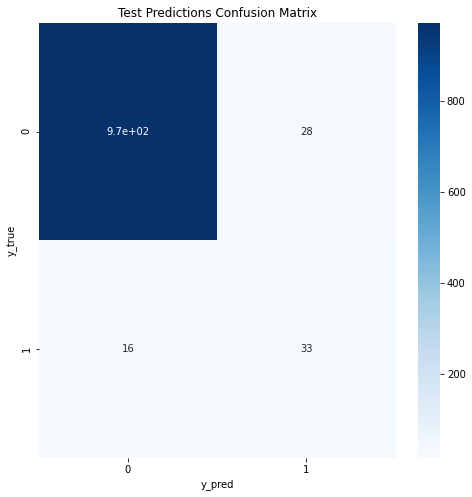

In [21]:
print(classification_report(test_true, test_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(test_true, test_pred), annot=True, cmap="Blues")
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title("Test Predictions Confusion Matrix")
plt.show()

### Stacked Ensemble Model: Using BERT Model Predictions as Feature Inputs into XGBoost Model

In [22]:
%%time 

train_pred = model.predict(train_input)
train_pred = train_pred.argmax(1)

CPU times: user 5.18 s, sys: 2.88 s, total: 8.06 s
Wall time: 1min 2s


In [23]:
%%time 

train_ =train.copy()
test_ = test.copy()

train_['bert_preds'] = train_pred
test_['bert_preds'] = test_pred

train_ = train_.drop(columns=['author','title','time_created','clock_time'])
test_ = test_.drop(columns=['author','title','time_created','clock_time'])

X_train = train_.drop(columns=['over_18'])
y_train = train_.over_18

X_test = test_.drop(columns=['over_18'])
y_test = test_.over_18

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


# grid search
xgb_model = XGBClassifier()
n_estimators = [50, 100, 200, 300, 400]
learning_rate = [0.00001, 0.0001, 0.001, 0.01]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, param_grid, scoring="recall", n_jobs=-1, cv=kfold)

xgb_grid_result = xgb_grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid_result.best_score_, xgb_grid_result.best_params_))

# make predictions for test data using best model
y_pred = xgb_grid_result.predict(X_test)

Best: 0.929894 using {'learning_rate': 0.001, 'n_estimators': 300}
CPU times: user 3.47 s, sys: 367 ms, total: 3.84 s
Wall time: 2min 14s


              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1000
        True       0.62      0.67      0.65        49

    accuracy                           0.97      1049
   macro avg       0.80      0.83      0.81      1049
weighted avg       0.97      0.97      0.97      1049



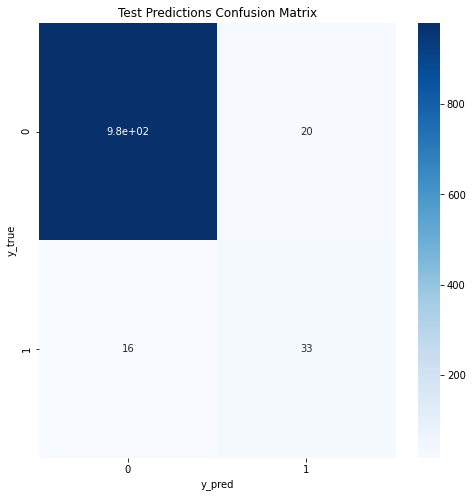

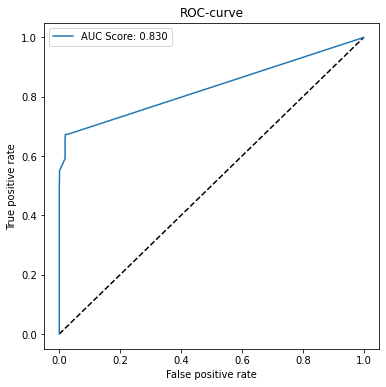

In [24]:
# Calculate the accuracy score: score
score = classification_report(y_test, y_pred)
print(score)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title("Test Predictions Confusion Matrix")
plt.show()

# calculating prediction probabilities on test set for roc_curve
y_pred_ = xgb_grid_result.predict_proba(X_test)
y_probs = y_pred_[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs, drop_intermediate=False)
auc_ = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC Score: {:.3f}'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-curve')
plt.legend(loc='best')
plt.show()

In [26]:
# saving dataframe and model

data_ = pd.concat([train_,test_])
data.to_csv('data/df_with_bert_over_18_feature.csv')


# save model to file
pickle.dump(xgb_model, open("./data/xgb_model_bert_over_18_feature.pkl", "wb"))